In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.sparse import hstack
import shap

In [2]:
# Load the data
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv', usecols=['userId', 'movieId', 'rating'])
tags = pd.read_csv('ml-latest-small/tags.csv', usecols=['userId', 'movieId', 'tag'])
links = pd.read_csv('ml-latest-small/links.csv')

In [3]:
# Prepare the data
# Group tags by userId and movieId, combining tags for each movie by each user
g = {i: lambda x: '|'.join(list(x)) for i in tags.columns[2:]}
tags = tags.groupby(['userId', 'movieId']).agg(g).reset_index()

In [4]:
# Merge movies with links, and merge reviews (ratings + tags) with movies
movies = pd.merge(movies, links, on=['movieId'])
reviews = pd.merge(ratings, tags, on=['userId', 'movieId'])
reviews = pd.merge(reviews, movies[['movieId', 'genres']], on='movieId')

In [5]:
# Calculate movie popularity as the number of ratings for each movie
movie_popularity = ratings.groupby('movieId').size().reset_index(name='movie_popularity')

# Calculate the average rating given by each user
user_avg_rating = ratings.groupby('userId')['rating'].mean().reset_index(name='user_avg_rating')

# Merge  data with the reviews dataframe
reviews = pd.merge(reviews, movie_popularity, on='movieId', how='left')
reviews = pd.merge(reviews, user_avg_rating, on='userId', how='left')

In [6]:
# Display frist 5 rows
print("Movies head:\n", movies.head())
print("Reviews head:\n", reviews.head())

Movies head:
    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  imdbId   tmdbId  
0  Adventure|Animation|Children|Comedy|Fantasy  114709    862.0  
1                   Adventure|Children|Fantasy  113497   8844.0  
2                               Comedy|Romance  113228  15602.0  
3                         Comedy|Drama|Romance  114885  31357.0  
4                                       Comedy  113041  11862.0  
Reviews head:
    userId  movieId  rating                                      tag  \
0       2    60756     5.0       funny|Highly quotable|will ferrell   
1       2    89774     5.0               Boxing story|MMA|Tom Hardy   
2       2   106782     5.0  drugs|Leonardo DiCaprio|Martin Sc

In [7]:
# Display data information
movies_info = (movies.shape[1], movies.shape[0])
ratings_info = (ratings.shape[1], ratings.shape[0])
tags_info = (tags.shape[1], tags.shape[0])
links_info = (links.shape[1], links.shape[0])
print(f"Movies: {movies_info[1]} records, {movies_info[0]} attributes")
print(f"Ratings: {ratings_info[1]} records, {ratings_info[0]} attributes")
print(f"Tags: {tags_info[1]} records, {tags_info[0]} attributes")
print(f"Links: {links_info[1]} records, {links_info[0]} attributes")

Movies: 9742 records, 5 attributes
Ratings: 100836 records, 3 attributes
Tags: 1775 records, 3 attributes
Links: 9742 records, 3 attributes


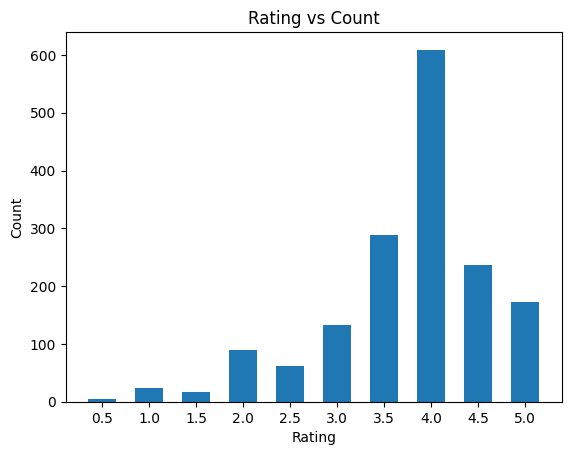

In [8]:
# Visualize rating distribution
ratings_df = reviews.groupby(by=['rating']).agg({'userId': 'count'}).rename(columns={'userId': 'count'}).reset_index()
plt.bar(ratings_df['rating'], ratings_df['count'], align='center', width=0.3)
plt.xticks(ratings_df['rating'])
plt.title("Rating vs Count")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [9]:
display(movies)

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,5476944,432131.0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,5914996,445030.0
9739,193585,Flint (2017),Drama,6397426,479308.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,8391976,483455.0


In [10]:
# Vectorize tags
tag_vectorizer = TfidfVectorizer()
tag_matrix = tag_vectorizer.fit_transform(reviews['tag'].fillna(''))

# Vectorize movie genres
genre_vectorizer = TfidfVectorizer()
genre_matrix = genre_vectorizer.fit_transform(reviews['genres'].fillna(''))

movie_popularity_vector = reviews['movie_popularity'].values.reshape(-1, 1)
movie_popularity_vector = (movie_popularity_vector - movie_popularity_vector.mean()) / movie_popularity_vector.std()
user_avg_rating_vector = reviews['user_avg_rating'].values.reshape(-1, 1)
user_avg_rating_vector = (user_avg_rating_vector - user_avg_rating_vector.mean()) / user_avg_rating_vector.std()

# Combine tag and genre vectors
X = hstack([tag_matrix, genre_matrix, movie_popularity_vector, user_avg_rating_vector])

# Prepare the target variable
y = reviews['rating']

In [11]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Define models
models = {
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(),
    'LinearRegression': LinearRegression(),
    'NeuralNetwork': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

In [13]:
# Train and evaluate models
results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'CV MSE': -cv_scores.mean(), 'MSE': mse, 'R²': r2}
    print(f'{name} - CV MSE: {-cv_scores.mean()}, Test MSE: {mse}, R²: {r2}')

DecisionTree - CV MSE: 1.07821137141353, Test MSE: 0.9128440366972477, R²: -0.39222370401009843
RandomForest - CV MSE: 0.6786515348431366, Test MSE: 0.5975585082533269, R²: 0.08863388894644897
GradientBoosting - CV MSE: 0.6592774695606843, Test MSE: 0.5532672146659059, R²: 0.1561847369935936
LinearRegression - CV MSE: 1.170548055647755, Test MSE: 0.8546283145100214, R²: -0.303436019458456
NeuralNetwork - CV MSE: 1.027508137442638, Test MSE: 0.9769004697371119, R²: -0.4899193462964839


In [14]:
# Select the best model
model = models['GradientBoosting']

In [15]:
#Grid Hiperparameters
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}

In [16]:
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
print(f'The best params: {grid_search.best_params_}')

The best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [17]:
# Predict ratings on the test set
y_test_pred = model.predict(X_test)

In [18]:
# Compare predicted ratings with actual ratings
results_df = pd.DataFrame({'Actual Rating': y_test, 'Predicted Rating': y_test_pred})
print(results_df.head(10))

      Actual Rating  Predicted Rating
937             4.5          4.018541
1097            4.5          3.844144
813             4.0          3.774068
607             4.5          3.861470
1304            4.0          3.441861
1074            4.0          3.821280
839             4.0          3.788121
809             4.5          3.703465
1237            4.0          3.685902
271             3.5          4.072658


In [19]:
# Calculate test metrics
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'Test MSE: {mse_test}')
print(f'Test R²: {r2_test}')

Test MSE: 0.5328100157383976
Test R²: 0.1873850254542313


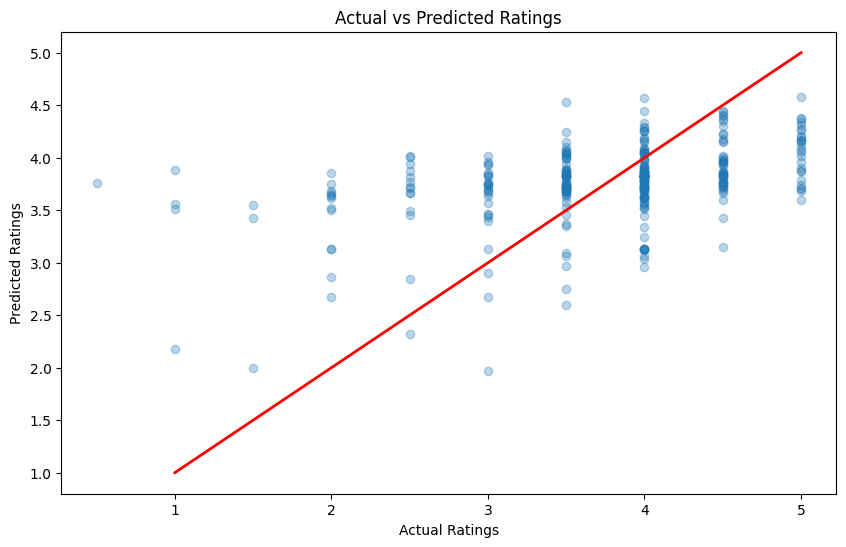

In [20]:
# Plot actual vs predicted ratings
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings')
plt.plot([1, 5], [1, 5], color='red', linewidth=2)  # Ideal line (y=x)
plt.show()

In [21]:
# Convert sparse matrix to dense matrix
X_test_dense = X_test.toarray()

In [22]:
# Analyze feature importance using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_dense, check_additivity=False)

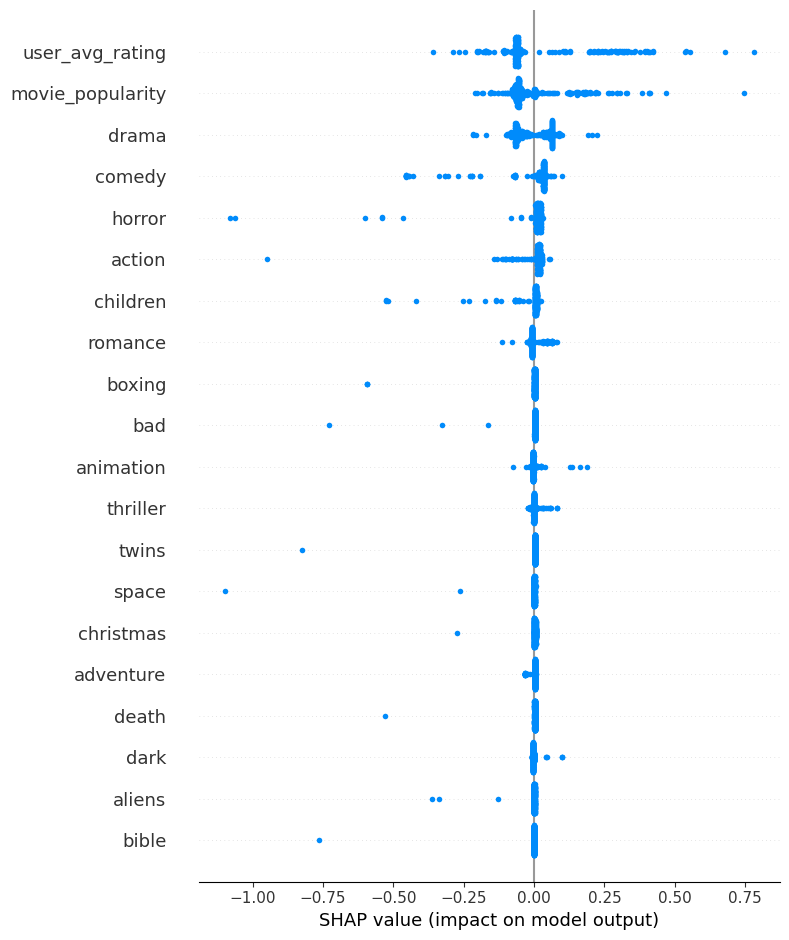

In [23]:
# Concatenate the feature names from both vectorizers along with additional feature names into a single array
all_feature_names = np.concatenate((
    tag_vectorizer.get_feature_names_out(),
    genre_vectorizer.get_feature_names_out(), 
    ['movie_popularity', 'user_avg_rating']
))
# Generate a SHAP summary plot
shap.summary_plot(shap_values, feature_names=all_feature_names)

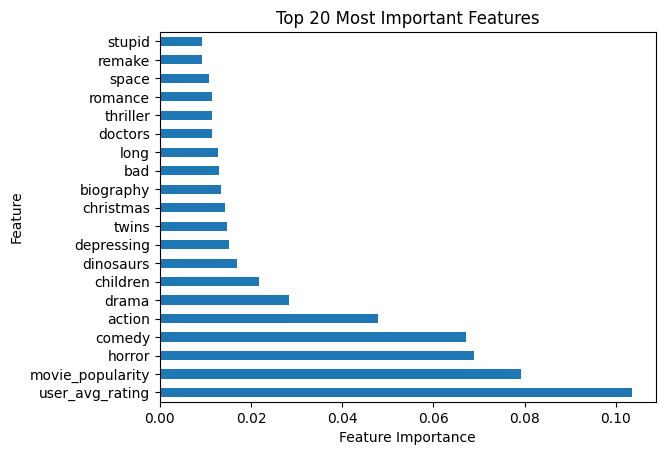

In [24]:
# Plot the top 20 most important features
feature_importances = pd.Series(model.feature_importances_, index=all_feature_names)
feature_importances.nlargest(20).plot(kind='barh')
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()